## Problem Set 4

**Total points (without extra credit)**: 30 

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers 
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset4_inputdata` (need to unzip): 

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers 


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset4_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [2]:
## your code 
import zipfile
with zipfile.ZipFile("pset4_inputdata.zip","r") as zip_ref:
    zip_ref.extractall()
    
df = pd.read_csv("pset4_inputdata/debar.csv")

## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [3]:
## your code here
len(df)
df["Name"].nunique()

105

94

There are multiple rows for some employers.

## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts 
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [4]:
## your code here
df["is_repeated"] = df.Name.duplicated(keep=False)

mult_debar = df[df.is_repeated]
mult_debar.head()
mult_debar.shape

,Name,"City, State",Violation,Start date,viol_num,is_repeated
0,Macky and Brad Farms,"Plains, TX",Impeding the Audit Process – Partial- Response,2/13/2015,viol1,True
9,Autumn Hill Orchard,"Groton, MA",Impeding the Audit Process – Non- Response,7/6/2014,viol2,True
14,Macky and Brad Farms,"Plains, TX",Failure to respond to audit (no response),2/13/2015,viol2,True
23,SRT Farms,"Morton, TX",Failure to respond to audit (no response),11/16/2014,viol1,True
24,Dove Creek Farms,"Mount Vernon, TX",Failure to Respond to Audit Request,2/9/2018,viol1,True


(22, 6)

There are several instances where an employer appears multiple times; the max number of times an employer appears is 2.

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data 
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same 

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [5]:
## your code here
mult_debar_wide = mult_debar.pivot(["Name", "City, State"], "viol_num", "Start date")
mult_debar_wide.columns = ["start_date_" + str(x) for 
                           x in mult_debar_wide.columns if "viol" in x]

mult_debar_wide = mult_debar_wide.reset_index()
mult_debar_wide.head()
mult_debar_wide.shape

C:\Users\keyasengupta\AppData\Local\Temp\ipykernel_14196\3603440639.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  mult_debar_wide = mult_debar.pivot(["Name", "City, State"], "viol_num", "Start date")


,Name,"City, State",start_date_viol1,start_date_viol2
0,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
1,Cisco Produce Inc.,"Cairo, GA",12/10/2015,12/10/2014
2,Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018
3,F&W Farms,"Ingalls, KS",12/10/2014,12/10/2014
4,Macky and Brad Farms,"Plains, TX",2/13/2015,2/13/2015


(11, 4)

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [6]:
## your code here
mult_debar_wide["is_dup"] = mult_debar_wide.start_date_viol1 == mult_debar_wide.start_date_viol2


debar_clean = pd.concat([df[df["Name"]\
                            .isin(mult_debar_wide[mult_debar_wide.is_dup].Name)][df["viol_num"] == "viol1"], 
                         df[~df["Name"].isin(mult_debar_wide[mult_debar_wide.is_dup].Name)]]).drop(columns="is_repeated")

debar_clean.shape
debar_clean.Name.nunique()

C:\Users\keyasengupta\AppData\Local\Temp\ipykernel_14196\1064485327.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  debar_clean = pd.concat([df[df["Name"]\


(97, 5)

94

# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021 

Loading the `jobs_clean.csv` data stored in `pset4_inputdata`

In [7]:
# your code here to load the data 

jobs = pd.read_csv("pset4_inputdata/jobs_clean.csv")

##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset 

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches. 

B. If there are exact matches, print the row(s) with exact matches



In [8]:
## your code here
jobs.merge(debar_clean, "inner", left_on="EMPLOYER_NAME", right_on="Name")

,CASE_NUMBER,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_ADDRESS_1,Name,"City, State",Violation,Start date,viol_num
0,H-300-20287-876656,Rafael Barajas,Port St. Lucie,FL,2598 SW Dalpina Rd.,Rafael Barajas,"Sebring, Florida",Non-payment of certification fee,9/23/2016,viol1


## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each 
of the employer name fields in each dataset 

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns 


In [9]:
## insert your code to turn into uppercase here

jobs["EMPLOYER_NAME"] = [name.upper() for name in jobs["EMPLOYER_NAME"]]
debar_clean.Name = [name.upper() for name in debar_clean.Name]

## insert your code for the random sample
jobs["EMPLOYER_NAME"].sample(15)
debar_clean.Name.sample(15)

539              SWEET RIVER COMPANY, LLC
441                          ERWIN TUPPER
56          CRAIG & SCOTT JONES LIVESTOCK
688                       SORG DAIRY, LLC
1541              CHAPPELL MILL TREES LLC
721                       S & T FARMS LLC
2388    SMITH RANCHO LAND & LIVESTOCK LLC
2003            WESTERN RANGE ASSOCIATION
667                         WIVHOLM FARMS
1055                    KYLE SIBERT FARMS
162                              B&G AGRI
803                      SHEB W. CALLAHAN
1355                          BANDY RANCH
2551                PUSHEN & PULLEN FARMS
240             WESTERN RANGE ASSOCIATION
Name: EMPLOYER_NAME, dtype: object

49                CISCO PRODUCE INC.
80             C HANGING L RANCH LLP
103    TRINITY LIVESTOCK PARTNERSHIP
101                      DONNA LUCIO
2               RB FARM PICKING, INC
1                      LABATTE FARMS
66             PEACH CREST FARM, LLC
50                      TODD DAULTON
73              ALTERIC JEAN-CHARLES
18          ALTENDORF TRANSPORT INC.
10            YOLANDA CHAVEZ FARMING
53                       PROMAX INC.
22                      WALKER PLACE
25     CITY PINESTRAW AND HARVESTING
86             MYRKA MIREYA CARDENAS
Name: Name, dtype: object

### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO 

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [10]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [11]:
## insert your code here with the regex pattern for part A
pattern = "(CO\.|INC\.|LLC\.)"

## insert your code to use re.sub to apply the pattern to the test cases for part B
new_vals = [re.sub(pattern, lambda x: x.group(0)[:-1], s) for s in [pos_example_1, pos_example_2, neg_example]]
print(new_vals)

['CISCO PRODUCE INC', 'AVOYELLES HONEY CO, LLC', 'E.V. RANCH LLP']


### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [12]:
## your code here to clean the columns
jobs["name_clean"] = [re.sub(pattern, lambda x: x.group(0)[:-1], s) for s in jobs["EMPLOYER_NAME"]]
debar_clean["name_clean"] = [re.sub(pattern, lambda x: x.group(0)[:-1], s) for s in debar_clean["Name"]]

debar_clean[debar_clean.Name != debar_clean.name_clean][["Name", "name_clean"]]
jobs[jobs["EMPLOYER_NAME"] != jobs.name_clean][["EMPLOYER_NAME", "name_clean"]]

,Name,name_clean
15,ANTON FERTILIZER INC.,ANTON FERTILIZER INC
18,ALTENDORF TRANSPORT INC.,ALTENDORF TRANSPORT INC
20,"GREAT PLAINS FLUID SERVICE, INC.","GREAT PLAINS FLUID SERVICE, INC"
21,REIMER'S INC.,REIMER'S INC
31,REIMER’S INC.,REIMER’S INC
49,CISCO PRODUCE INC.,CISCO PRODUCE INC
53,PROMAX INC.,PROMAX INC
61,"SAXTONS RIVER ORCHARDS, INC.","SAXTONS RIVER ORCHARDS, INC"
70,CISCO PRODUCE INC.,CISCO PRODUCE INC
76,"AVOYELLES HONEY CO., LLC","AVOYELLES HONEY CO, LLC"


,EMPLOYER_NAME,name_clean
4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC"
7,"FARM LABOR ASSOCIATION FOR GROWERS, INC.","FARM LABOR ASSOCIATION FOR GROWERS, INC"
14,"MCLAIN FARMS, INC.","MCLAIN FARMS, INC"
17,"BONNIE PLANTS, INC.","BONNIE PLANTS, INC"
18,"B & W QUALITY GROWERS, INC.","B & W QUALITY GROWERS, INC"
...,...,...
2700,HARRAL LIVESTOCK CO. LLC,HARRAL LIVESTOCK CO LLC
2701,ECOSYSTEM CONCEPTS INC.,ECOSYSTEM CONCEPTS INC
2702,SIDDOWAY SHEEP CO.,SIDDOWAY SHEEP CO
2705,SATHER MANAGEMENT INC.,SATHER MANAGEMENT INC


In [13]:
## your code here to print the head
jobs.head()
debar_clean.head()

,CASE_NUMBER,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_ADDRESS_1,name_clean
0,H-300-20199-721302,"FAZIO FARMS OPERATING COMPANY, LLC",Portland,OR,8433 NE 13th Ave,"FAZIO FARMS OPERATING COMPANY, LLC"
1,H-300-20231-773906,CHARLIE SUNDERLAND,McMinnville,TN,982 Northcutts Cove Road,CHARLIE SUNDERLAND
2,H-300-20231-774123,MICHAEL RUDEBUSCH,Livingston,TX,7366 State Hwy 146 S,MICHAEL RUDEBUSCH
3,H-300-20231-774151,LODAHL FARMS,Brockton,MT,4198 Road 2049,LODAHL FARMS
4,H-300-20231-774508,"DUNSON HARVESTING, INC.",Winter Haven,FL,400 Eagle Lake Loop Rd.,"DUNSON HARVESTING, INC"


,Name,"City, State",Violation,Start date,viol_num,name_clean
0,MACKY AND BRAD FARMS,"Plains, TX",Impeding the Audit Process – Partial- Response,2/13/2015,viol1,MACKY AND BRAD FARMS
23,SRT FARMS,"Morton, TX",Failure to respond to audit (no response),11/16/2014,viol1,SRT FARMS
24,DOVE CREEK FARMS,"Mount Vernon, TX",Failure to Respond to Audit Request,2/9/2018,viol1,DOVE CREEK FARMS
44,ROLLO FARM LABOR CONTRACTOR,"Miami, FL",Failure to respond to audit (no response),8/23/2014,viol1,ROLLO FARM LABOR CONTRACTOR
48,F&W FARMS,"Ingalls, KS",Impeding the Audit Process – Partial- Response,12/10/2014,viol1,F&W FARMS


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate the fuzzy matching we'll cover in future week or optional OH; that fuzzy matching would recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical

In [14]:
## your code here
jobs.merge(debar_clean, "inner", left_on="name_clean", right_on="name_clean")

,CASE_NUMBER,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_ADDRESS_1,name_clean,Name,"City, State",Violation,Start date,viol_num
0,H-300-20287-876656,RAFAEL BARAJAS,Port St. Lucie,FL,2598 SW Dalpina Rd.,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,9/23/2016,viol1


In [15]:
jobs["name_clean_2"] = [re.sub(r"\.|\sLLP", "", n) for n in jobs.name_clean]
debar_clean["name_clean_2"] = [re.sub(r"\.|\sLLP", "", n) for n in debar_clean.name_clean]
tmp_df = jobs.merge(debar_clean, "left", on="name_clean_2", indicator="merge_status")
tmp_df[tmp_df.merge_status=="both"]

,CASE_NUMBER,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_ADDRESS_1,name_clean_x,name_clean_2,Name,"City, State",Violation,Start date,viol_num,name_clean_y,merge_status
791,H-300-20287-876656,RAFAEL BARAJAS,Port St. Lucie,FL,2598 SW Dalpina Rd.,RAFAEL BARAJAS,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,9/23/2016,viol1,RAFAEL BARAJAS,both
1115,H-300-20306-894148,SLASH EV RANCH,Rifle,CO,22593 County Road 5,SLASH EV RANCH,SLASH EV RANCH,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,11/15/2014,viol1,SLASH E.V. RANCH LLP,both


# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM 
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [16]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## your code here to define the pattern
pattern = r"(.*)\s\(COMPANY\)|AND\s(.*)\s\(INDIVIDUAL\)"

## your code here to apply it to the pos_example
re.findall(pattern, pos_example)

## your code here to apply it to the negative example
re.findall(pattern, neg_example)

[('COUNTY FAIR FARM', ''), ('', 'ANDREW WILLIAMSON')]

[]

C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)
 


In [17]:
# your code here
debar_clean["co_name"] = [re.findall(pattern,n)[0][0] if re.findall(pattern, n) != [] else None for n in debar_clean.name_clean]
debar_clean["ind_name"] = [re.findall(pattern,n)[1][1] if len(re.findall(pattern, n)) > 1 else None for n in debar_clean.name_clean]

   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [18]:
# your code here
debar_clean[debar_clean.name_clean == pos_example][["name_clean", "co_name", "ind_name", "Violation"]]
debar_clean[debar_clean.name_clean == neg_example][["name_clean", "co_name", "ind_name", "Violation"]]

,name_clean,co_name,ind_name,Violation
84,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment


,name_clean,co_name,ind_name,Violation
49,CISCO PRODUCE INC,None,None,Impeding the Audit Process – Non- Response
70,CISCO PRODUCE INC,None,None,Failure to respond to audit (no response)


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia 
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data. 
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/ 
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1` 
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

In [19]:
## your code here
import geopandas as gpd
import matplotlib.pyplot as plt
import config 
import requests
import pprint

subset = jobs[(jobs["EMPLOYER_STATE"] == "GA") & 
              (~jobs["EMPLOYER_ADDRESS_1"].str.contains("PO Box")) & 
              (~jobs["EMPLOYER_ADDRESS_1"].str.contains("P O BOX"))
             ].copy()
subset = subset[subset["EMPLOYER_NAME"] != "ROJAS AVILA HARVESTING, LLC"]

subset["geocoded"] = [tuple(requests.get(f"https://api.mapbox.com/geocoding/v5/mapbox.places/{re.sub('#', '', subset.iloc[a]['EMPLOYER_ADDRESS_1'])} {re.sub('#', '', subset.iloc[a]['EMPLOYER_CITY'])} {re.sub('#', '', subset.iloc[a]['EMPLOYER_STATE'])}.json", 
                   params={"access_token": config.api_token}).json()["features"][0]["center"]) 
                      for a in range(len(subset))]

In [20]:
%matplotlib inline

C:\Users\keyasengupta\anaconda2\envs\py38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot: >

<AxesSubplot: >

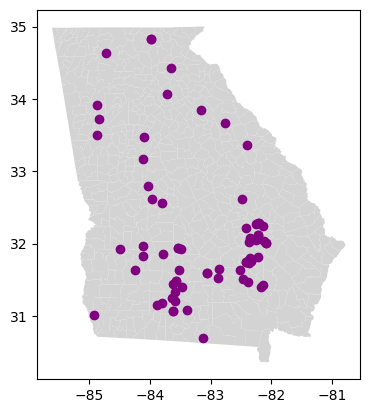

In [22]:
from shapely.geometry import Point

georgia = gpd.read_file("pset4_inputdata/tl_2019_13_cousub.shp")

geom = [Point(x) for x in subset.geocoded]
geo_df = gpd.GeoDataFrame(subset, 
                          crs = {'init':'EPSG:4326'}, 
                          geometry = geom)

fig, ax = plt.subplots()
georgia.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df["geometry"].plot(ax=ax, color="purple")